In [111]:
import scipy
from scipy.signal import butter, lfilter
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz
%matplotlib inline


def read_samples_scipy(filename, blocklen):
    
    iq_samples = scipy.fromfile(filename, 
                                dtype=scipy.complex64, 
                                count=blocklen)
    return iq_samples



In [112]:
def PSD(x, fs):
    
    f, Pxx_den = signal.periodogram(x, fs)
    return f,Pxx_den

iq_samples = scipy.fromfile("..//..//data/samples1.dat", dtype=scipy.complex64)
f, Pxx_den = PSD(iq_samples,3e6)


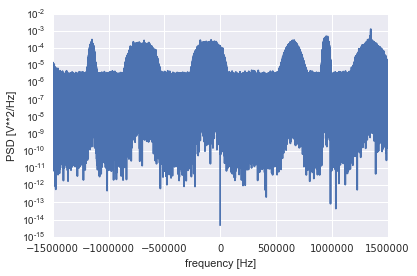

In [113]:
f, Pxx_den = PSD(iq_samples,3e6)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')


In [127]:
import pandas as pd
import json
from pprint import pprint

def breakbins(PSD,f):
    total_points = PSD.shape[0]
    bins = np.split(PSD, 30)
    fbins = np.split(f, 30)
    keys = [x.min() for x in fbins]
    df= pd.DataFrame(columns=['min_freq','freq','psd'])
    for i in range(30):
        df = df.append(pd.DataFrame([(keys[i],fbins[i],bins[i])],columns=['min_freq','freq','psd']),ignore_index=True)

    df = df.sort('min_freq')
    df['bin'] = range(30)
    
    
    return df

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def ComputeFreqFeatures(Px,f):
    
    df = breakbins(Px,f)
    df.psd = df.psd.apply(lambda x: np.log(x))
    df['PSDmax']= df.psd.apply(max)
    df['PSDmin']= df.psd.apply(min)
    df['PSDmean']= df.psd.apply(np.mean)
    df['PSDstd']= df.psd.apply(np.std)
    
    return df

def AddLabel(filepath,df):
    with open(filepath) as data_file:    
        data = json.load(data_file)

    df['modulation_type'] = "NOISE"

    for sig in data['signals']:
        print sig['modulation_type'], sig['occupied_bins']
        indx = df[df.bin.isin(sig['occupied_bins'])].index
        df.loc[indx,'modulation_type'] = sig['modulation_type']
    
    return df



In [115]:
import os, sys
filesource = "..//../data"
dirs = os.listdir( "..//../data" )
files =[]
for i in dirs:    
    files.append('{0}/{1}'.format(filesource,i))

bandplan = [s for s in files if "bandplan" in s]
samples = [s for s in files if "samples" in s]

df= pd.DataFrame(columns=['min_freq','freq', 'psd','bin','PSDmax','PSDmin','PSDmean','PSDstd','modulation_type'])

for i in range((len(files)/2)-2):
    print bandplan[i],samples[i]
    iq_samples = scipy.fromfile(samples[i], dtype=scipy.complex64)
    fi, Pxi = PSD(iq_samples,3e6)
    tmpdf = ComputeFreqFeatures(Pxi,fi)
    tmpdf = AddLabel(bandplan[i],tmpdf)
    df = df.append(tmpdf)
    
    

..//../data/bandplan.json ..//../data/samples.dat
FM [20, 21, 22, 23]
GMSK [4, 5]
QPSK [8, 9, 10, 11]
QPSK [17]
GMSK [1, 2]
QPSK [25]
..//../data/bandplan1.json ..//../data/samples1.dat
QPSK [24]
QPSK [8, 9, 6, 7]
GMSK [20, 21, 22]
FM [27, 28, 29]
GMSK [3]
QPSK [12, 13, 14, 15]
..//../data/bandplan10.json ..//../data/samples10.dat
GMSK [6, 7]
FM [2]
QPSK [16, 17, 18, 19]
FM [24, 25, 26]
GMSK [14]
QPSK [10, 11, 12]
..//../data/bandplan11.json ..//../data/samples11.dat
GMSK [17]
QPSK [24, 25, 26, 27]
FM [7]
GMSK [29]
QPSK [15]
FM [4]
..//../data/bandplan12+1.json ..//../data/samples12+1.dat
QPSK [2, 3, 4]
QPSK [27, 28]
QPSK [22, 23]
GMSK [12]
FM [9]
QPSK [14]
..//../data/bandplan12.json ..//../data/samples12.dat
FM [24, 23]
GMSK [19, 20, 21]
GMSK [11, 12, 13, 14]
FM [3]
QPSK [27]
QPSK [8, 7]
..//../data/bandplan14.json ..//../data/samples14.dat
QPSK [16, 17]
QPSK [29]
GMSK [24, 25, 26, 27]
QPSK [4, 5, 6, 7]
GMSK [19]
GMSK [13, 14]
..//../data/bandplan15.json ..//../data/samples15.dat
GMS

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [116]:
print df.shape, df[df.modulation_type == 'NOISE'].shape,df[df.modulation_type == 'FM'].shape
print df[df.modulation_type == 'QPSK'].shape, df[df.modulation_type == 'GMSK'].shape
df.head()

(510, 9) (271, 9) (59, 9)
(105, 9) (75, 9)


,min_freq,freq,psd,bin,PSDmax,PSDmin,PSDmean,PSDstd,modulation_type
15,-1500000.0,"[-1500000.0, -1499999.66667, -1499999.33333, -...","[-17.4853, -15.3664, -14.7356, -15.3607, -15.2...",0.0,-12.345955,-28.594597,-15.485013,1.285630,NOISE
16,-1400000.0,"[-1400000.0, -1399999.66667, -1399999.33333, -...","[-14.8683, -15.847, -13.8171, -14.1555, -18.24...",1.0,-7.830736,-26.906197,-12.845067,2.068613,GMSK
17,-1300000.0,"[-1300000.0, -1299999.66667, -1299999.33333, -...","[-9.88674, -9.70047, -11.7473, -11.4466, -10.5...",2.0,-7.967446,-30.726082,-12.845821,2.069172,GMSK
18,-1200000.0,"[-1200000.0, -1199999.66667, -1199999.33333, -...","[-16.3378, -16.083, -18.3168, -14.3582, -14.02...",3.0,-12.427369,-29.113277,-15.473349,1.284488,NOISE
19,-1100000.0,"[-1100000.0, -1099999.66667, -1099999.33333, -...","[-17.0148, -16.06, -14.9699, -14.866, -18.6512...",4.0,-7.553216,-26.589058,-12.688860,2.113428,GMSK


## Phase 1: Identify Noise 

In [117]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df.modulation_type)
df['Label'] = le.transform(df.modulation_type)

# Split Train and Test set
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

x_train = train[['PSDmax','PSDmin','PSDmean','PSDstd']]
x_test = test[['PSDmax','PSDmin','PSDmean','PSDstd']]

y_train = train.Label.values
y_test = test.Label.values


In [118]:
df.head(10)

,min_freq,freq,psd,bin,PSDmax,PSDmin,PSDmean,PSDstd,modulation_type,Label
15,-1500000.0,"[-1500000.0, -1499999.66667, -1499999.33333, -...","[-17.4853, -15.3664, -14.7356, -15.3607, -15.2...",0.0,-12.345955,-28.594597,-15.485013,1.285630,NOISE,2
16,-1400000.0,"[-1400000.0, -1399999.66667, -1399999.33333, -...","[-14.8683, -15.847, -13.8171, -14.1555, -18.24...",1.0,-7.830736,-26.906197,-12.845067,2.068613,GMSK,1
17,-1300000.0,"[-1300000.0, -1299999.66667, -1299999.33333, -...","[-9.88674, -9.70047, -11.7473, -11.4466, -10.5...",2.0,-7.967446,-30.726082,-12.845821,2.069172,GMSK,1
18,-1200000.0,"[-1200000.0, -1199999.66667, -1199999.33333, -...","[-16.3378, -16.083, -18.3168, -14.3582, -14.02...",3.0,-12.427369,-29.113277,-15.473349,1.284488,NOISE,2
19,-1100000.0,"[-1100000.0, -1099999.66667, -1099999.33333, -...","[-17.0148, -16.06, -14.9699, -14.866, -18.6512...",4.0,-7.553216,-26.589058,-12.688860,2.113428,GMSK,1
20,-1000000.0,"[-1000000.0, -999999.666667, -999999.333333, -...","[-9.66152, -9.23167, -11.3538, -11.3053, -10.5...",5.0,-7.760303,-26.102737,-12.690907,2.115136,GMSK,1
21,-900000.0,"[-900000.0, -899999.666667, -899999.333333, -8...","[-16.7485, -17.5404, -15.9716, -16.3344, -15.4...",6.0,-12.297966,-27.490423,-15.477045,1.280378,NOISE,2
22,-800000.0,"[-800000.0, -799999.666667, -799999.333333, -7...","[-14.253, -18.4733, -16.1362, -16.1905, -13.76...",7.0,-12.323905,-27.887745,-15.487765,1.278953,NOISE,2
23,-700000.0,"[-700000.0, -699999.666667, -699999.333333, -6...","[-15.3165, -14.447, -15.0449, -14.5555, -15.68...",8.0,-8.738052,-25.905294,-13.799580,1.959877,QPSK,3
24,-600000.0,"[-600000.0, -599999.666667, -599999.333333, -5...","[-11.2922, -12.6647, -9.91717, -9.60155, -12.2...",9.0,-7.888948,-23.046705,-11.051927,1.297023,QPSK,3


In [119]:
y_train.shape, y_test.shape, x_train.shape, x_test.shape

((416L,), (94L,), (416, 4), (94, 4))

In [120]:

rf =RandomForestClassifier(n_estimators= 300)
lr = LogisticRegression().fit(x_train, y_train)

rf.fit(x_train,y_train)

print "Train RF ACC:", accuracy_score(y_train, rf.predict(x_train))
print "Test RF ACC:", accuracy_score(y_test, rf.predict(x_test))

print "Train LR ACC:", accuracy_score(y_train, np.round(lr.predict(x_train)))
print "Test LR ACC:", accuracy_score(y_test, np.round(lr.predict(x_test)))

Train RF ACC: 1.0
Test RF ACC: 0.936170212766
Train LR ACC: 0.802884615385
Test LR ACC: 0.840425531915


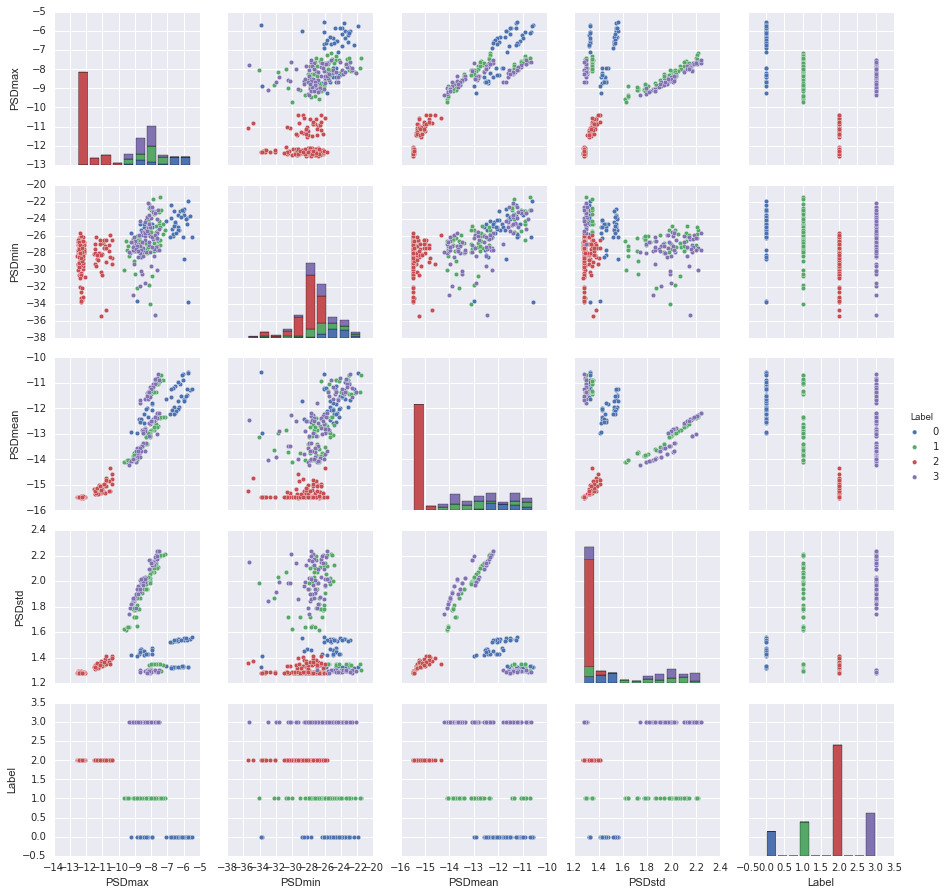

In [121]:
import seaborn as sns
plt.figure()
sns.pairplot(data=train[['PSDmax','PSDmin','PSDmean','PSDstd','Label']],
             hue="Label", dropna=True)


In [122]:
rf.feature_importances_

array([ 0.39419838,  0.04129778,  0.32027592,  0.24422792])

In [123]:
train.groupby('modulation_type').describe()

Label      PSDmax     PSDmean      PSDmin      PSDstd  \
modulation_type                                                                
FM              count   47.0   47.000000   47.000000   47.000000   47.000000   
                mean     0.0   -7.015504  -11.759745  -25.220459    1.447940   
                std      0.0    1.125709    0.618013    2.351348    0.087147   
                min      0.0   -9.243736  -12.974678  -33.837517    1.320989   
                25%      0.0   -8.225173  -12.215765  -25.797445    1.331392   
                50%      0.0   -6.606757  -11.807385  -24.687019    1.452557   
                75%      0.0   -6.086066  -11.254473  -23.921250    1.534854   
                max      0.0   -5.519174  -10.567950  -21.932043    1.559905   
GMSK            count   67.0   67.000000   67.000000   67.000000   67.000000   
                mean     1.0   -8.204816  -12.663822  -26.294096    1.759496   
                std      0.0    0.647681    1.091986    2.401446    0.313799   
                min      1.0   -9.689582  -14.101258  -34.073112    1.293189   
                25%      1.0   -8.793304  -13.674376  -27.400198    1.350267   
                50%      1.0   -8.090884  -12.845821  -26.245373    1.784932   
                75%      1.0   -7.681336  -11.422212  -24.983025    2.030758   
                max      1.0   -7.131660  -10.708900  -21.493286    2.212937   
NOISE           count  218.0  218.000000  218.000000  218.000000  218.000000   
                mean     2.0  -12.122325  -15.423629  -28.147691    1.294530   
                std      0.0    0.523438    0.174635    1.635447    0.028557   
                min      2.0  -12.530403  -15.498098  -35.483479    1.275790   
                25%      2.0  -12.401751  -15.492841  -28.698613    1.280901   
                50%      2.0  -12.326126  -15.489569  -27.737264    1.283875   
                75%      2.0  -12.213259  -15.477387  -27.094074    1.286327   
                max      2.0  -10.393427  -14.338935  -25.691774    1.415832   
QPSK            count   84.0   84.000000   84.000000   84.000000   84.000000   
                mean     3.0   -8.313966  -12.625913  -26.597369    1.800725   
                std      0.0    0.496031    1.054848    2.348237    0.349763   
                min      3.0   -9.337093  -14.216534  -35.302704    1.281124   
                25%      3.0   -8.677744  -13.595159  -27.652869    1.300254   
                50%      3.0   -8.265284  -12.594487  -26.756159    1.935375   
                75%      3.0   -7.884456  -11.595559  -25.208009    2.048591   
                max      3.0   -7.527695  -10.665142  -22.183706    2.239313   

                              bin      min_freq  
modulation_type                                  
FM              count   47.000000  4.700000e+01  
                mean    16.787234  1.787234e+05  
                std      8.329978  8.329978e+05  
                min      1.000000 -1.400000e+06  
                25%     10.000000 -5.000000e+05  
                50%     18.000000  3.000000e+05  
                75%     24.000000  9.000000e+05  
                max     28.000000  1.300000e+06  
GMSK            count   67.000000  6.700000e+01  
                mean    14.552239 -4.477612e+04  
                std      8.651999  8.651999e+05  
                min      0.000000 -1.500000e+06  
                25%      7.500000 -7.500000e+05  
                50%     14.000000 -1.000000e+05  
                75%     22.000000  7.000000e+05  
                max     29.000000  1.400000e+06  
NOISE           count  218.000000  2.180000e+02  
                mean    14.587156 -4.128440e+04  
                std      9.021440  9.021440e+05  
                min      0.000000 -1.500000e+06  
                25%      7.000000 -8.000000e+05  
                50%     15.000000  0.000000e+00  
                75%     22.000000  7.000000e+05  
                max     29.000000  1.400000e+06  
QP

# Predict and test Succes 

In [124]:
# pickle the clf 

from sklearn.externals import joblib
joblib.dump(rf, 'clf/RF.pkl') 
joblib.dump(le, 'clf/LabelEncoder.pkl')

rf_l = joblib.load('clf/RF.pkl')
le_l = joblib.load('clf/LabelEncoder.pkl')

bandplan = '..//../data/bandplan9.json'
samples = '..//../data/samples9.dat'


iq_samples = scipy.fromfile(samples, dtype=scipy.complex64)
fi, Pxi = PSD(iq_samples,3e6)
tmpdf = ComputeFreqFeatures(Pxi,fi)
tmpdf = AddLabel(bandplan,tmpdf)

def predict_h2(df):
    return rf.predict(df[['PSDmax','PSDmin','PSDmean','PSDstd']])
    
print le_l.inverse_transform(predict_h2(tmpdf))
#print accuracy_score(y_train, predict_h2(tmpdf))

FM [6, 7]
FM [16, 17, 15]
QPSK [12]
QPSK [1, 2, 3]
GMSK [25]
QPSK [19, 20, 21, 22]
['NOISE' u'QPSK' u'QPSK' u'QPSK' 'NOISE' 'NOISE' u'FM' u'FM' 'NOISE'
 'NOISE' 'NOISE' 'NOISE' u'QPSK' 'NOISE' 'NOISE' u'FM' u'FM' u'FM' 'NOISE'
 u'GMSK' u'QPSK' u'QPSK' u'GMSK' 'NOISE' 'NOISE' u'GMSK' 'NOISE' 'NOISE'
 'NOISE' 'NOISE']


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [125]:
noise = le_l.transform('NOISE')
ans = predict_h2(tmpdf)

prev_noise =True
ls = []
for i in range(len(ans)):
    if prev_noise:
        #New Signal
        if ans[i] != noise:
            prev_noise = False
            ls.append(ans[i])
    else:
        #Current Signal
        if ans[i] != noise:
            ls.append(ans[i])
        else:
            prev_noise = True
            consensus_value = scipy.stats.mode(ls)
            for j in range(len(ls)):
                ans[i-len(ls)+j] = consensus_value[0][0]            
            
            ls=[]


smooth = le_l.inverse_transform(ans)            

In [146]:
bandplan = '..//../data/bandplan8.json'
samples = '..//../data/samples8.dat'


iq_samples = scipy.fromfile(samples, dtype=scipy.complex64)
fi, Pxi = PSD(iq_samples,3e6)
tmpdf = ComputeFreqFeatures(Pxi,fi)
tmpdf = AddLabel(bandplan,tmpdf)

def predict_h2(df):
    return rf.predict(df[['PSDmax','PSDmin','PSDmean','PSDstd']])
    
print le_l.inverse_transform(predict_h2(tmpdf))

GMSK [8, 9]
QPSK [21, 22]
GMSK [29]
GMSK [17, 18]
FM [3]
FM [11, 12]
['NOISE' 'NOISE' 'NOISE' u'FM' 'NOISE' 'NOISE' 'NOISE' 'NOISE' u'GMSK'
 u'GMSK' 'NOISE' u'FM' u'FM' 'NOISE' 'NOISE' 'NOISE' 'NOISE' u'GMSK'
 u'GMSK' 'NOISE' 'NOISE' u'QPSK' u'QPSK' 'NOISE' 'NOISE' 'NOISE' 'NOISE'
 'NOISE' 'NOISE' u'GMSK']


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


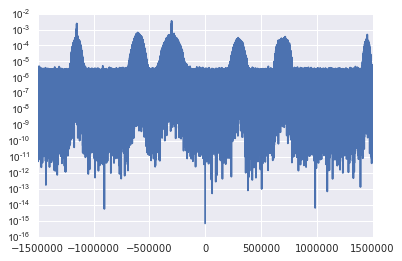

In [148]:

plt.semilogy(fi, Pxi)


[  1.60789819e-04 +2.31453410e-04j  -1.95743911e-03 -1.05363716e-03j
   7.81923982e-03 +3.08172198e-03j ...,  -4.68870284e-01 -1.08494379e+00j
   5.63344456e-01 +1.02974184e+00j  -6.49597411e-01 -9.45993713e-01j]
[ 0.17571111+0.25293228j -1.15777814+0.26116133j -0.58893025+0.98594666j
 ...,  3.15026164+5.48426914j  2.22518778+0.31063259j
 -4.29882812+0.36286306j]


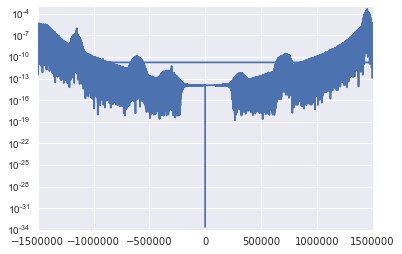

In [156]:
y = butter_bandpass_filter(iq_samples,1400e3,1499e3,3e6,order=3)
fi, Pxi = PSD(y,3e6)
print y
print iq_samples
plt.semilogy(fi, Pxi)


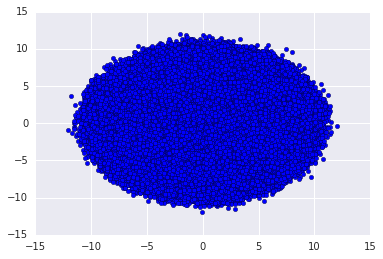

In [159]:
plt.scatter(iq_samples.real,iq_samples.imag)


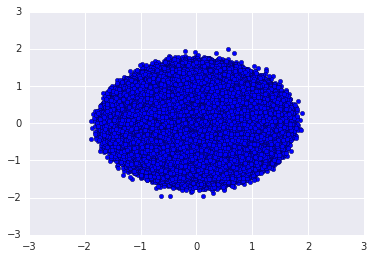

In [160]:
plt.scatter(y.real,y.imag)